In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levy_stable
from scipy import stats
from collections import Counter
import math


In [2]:
data = pd.read_csv('log_return_data.csv')
data


,log_return_vkco,log_return_tcs_il,log_return_poly_il,log_return_five_il
0,-0.012110,-0.004162,-0.003712,-0.013377
1,-0.035292,0.000000,-0.029352,-0.024070
2,0.011583,0.002083,-0.013279,0.007894
3,-0.006740,0.004154,0.025964,-0.002916
4,-0.009709,0.015425,-0.010984,-0.007034
...,...,...,...,...
248,-0.007648,0.018653,0.030041,0.010193
249,0.019012,0.044184,0.029452,-0.006216
250,0.018657,0.038540,0.008584,0.036732
251,0.046940,0.035287,0.042393,0.000000


### Для нахождения параметров воспользуемся формулой:  
### $ ln(-ln(\phi^2(|t|))) = ln(2\sigma^2) + \alpha ln(|t|),$ где $\phi$ — характерестическая функция распределения 

In [3]:
def charact_distr_func(t, dataframe, name, N):
    (y, x, _) = plt.hist(dataframe[name], bins=N)
    plt.close()
    x = x[:-1] - 1 # сдвигаю х на -1
    y = y / 253
    answer = 0
    for i in range(len(x)):
        id = complex(0, t * x[i])
        answer += math.exp(id.imag) * y[i]
    return answer

In [4]:
def get_log_log(t, dataframe, name, N):
    a = abs(charact_distr_func(t, data, name, N))
    return np.log(-np.log(abs(a) ** 2))

In [5]:
def get_mass_x_and_mass_y(dataframe, column):
    x = np.array([])
    Y = np.array([])

    # функцию для отрицательных аргументов можно не рассматривать 
    xx = np.arange(0.1, 20.0, 0.05)
    for i in xx:
        x = np.append(x, i)
        Y = np.append(Y, get_log_log(i, dataframe, column, 50))
    return x, Y

In [6]:
def get_alpha_and_sigma(mass_x, mass_y):
    N = 50
    log_mass_x = np.log(mass_x)
    mx = sum(log_mass_x) / N
    my = sum(mass_y) / N
    a2 = np.dot(log_mass_x.T, log_mass_x) / N
    a11 = np.dot(log_mass_x.T, mass_y) / N
    alpha = (a11 - mx * my) / (a2 - mx ** 2)
    sigma_2 = my - alpha * mx
    return alpha, sigma_2


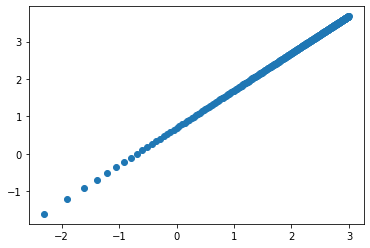

In [7]:
mass_x, mass_y = get_mass_x_and_mass_y(data, 'log_return_vkco')
log_mass_x = np.log(mass_x)
plt.scatter(log_mass_x, mass_y)

### Воспользуемся встроенными функциями


In [8]:
def get_x_y_from_dataframe(dataframe, name, N):
    (y, x, _) = plt.hist(dataframe[name], bins=N)
    plt.close()
    y = y / sum(abs(y))
    return x, y

In [9]:
def get_x_y(data, N):
    (y, x, _) = plt.hist(data, bins=N)
    plt.close()
    y = y / sum(abs(y))
    return x, y

In [10]:
def det_stable_distr_params(dataframe, columns):
    alpha, beta = 1.0, 0.5
    # use scipy's quantile estimator to estimate the parameters and convert to S parameterization
    pconv = lambda alpha, beta, mu, sigma: (alpha, beta, mu, sigma)
    return pconv(*levy_stable._fitstart(dataframe[columns]))


In [11]:
# сохраняем файл с параметрами
df = pd.DataFrame(columns = ['alpha', 'beta', 'mu', 'sigma'])
for col in data.columns:
    alpha, beta, mu, sigma = det_stable_distr_params(data, col)
    dat = {'alpha':alpha, 'beta':beta, 'mu':mu, 'sigma':sigma}
    df = df.append(dat, ignore_index=True)
    
df = df.rename(mapper={0: 'vkco', 1: 'tcs_il', 2: 'poly_il', 3: 'five_il'})
df.to_csv('params_stable_distribution.csv', index=True)

In [70]:
def show_two_graphics(dataframe, columns):
    pconv = lambda alpha, beta, mu, sigma: (alpha, beta, mu, sigma)
    alpha, beta, _, _ = pconv(*levy_stable._fitstart(dataframe[columns]))
    r = levy_stable.rvs(alpha, beta, size=100)
    r = r / sum(abs(r))
    (y, x, _) = plt.hist(r, bins=40)
    x = x[:-1]
    y = y / sum(abs(y))
    plt.close()

    (y0, x0, _) = plt.hist(dataframe[columns], bins=50)
    x0 = x0[:-1]
    y0 = y0 / sum(abs(y0))
    plt.close()

    plt.figure()
    plt.plot(x0, y0)
    plt.plot(x, y)
    print(str(col), stats.ks_2samp(y, y0)[1])

log_return_vkco 0.00018013289602944961


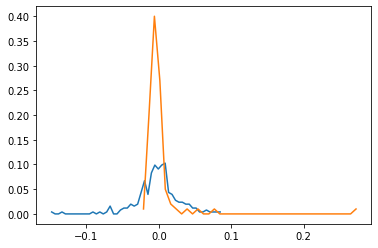

log_return_tcs_il 0.5286150381408532


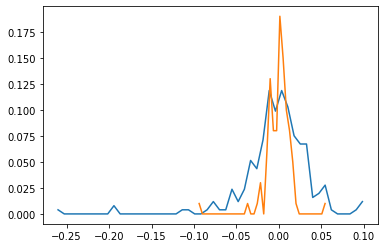

log_return_poly_il 0.8690061339673806


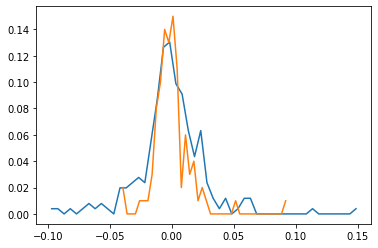

log_return_five_il 0.5676093958756026


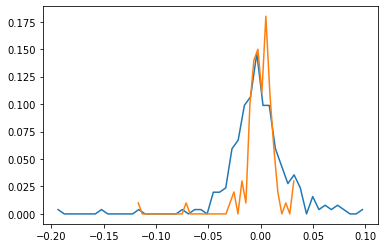

In [71]:
for col in data.columns:
    show_two_graphics(data,col)
    plt.show()